In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax
import flax.linen as nn
from flax.training import train_state, checkpoints
import jax 
import torch
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"

import optax

# fix random seed for reproducibility
np.random.seed(0)
key = jax.random.PRNGKey(0)
torch.manual_seed(0)

In [3]:
from typing import Sequence

def identity_weight_init():
    def init(key, shape, dtype=jnp.float32):
        w = jnp.eye(shape[0], shape[1], dtype=dtype) * 0.9
        w = w.at[-1, :].set(1.0)
        return w
    return init

class minGRULayer(nn.Module):
    '''
    MGU Layer
    We use a modified version of the h_tilde calculation in the MGU cell for better performance.
    - $f_t = \sigma(W^{fx} x_t + U^{fh} h_{t-1} + b^f)$
    - $\~{h}_t = \tanh(W^{hx} x_t + f_t \odot (U^{hh} h_{t-1} + b^h))$
    
    Args:
        hidden_size: int, size of hidden state
        output_size: int, size of output
    '''
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):

        def update(self, state, x):
            h = state[0]
            z_htilde = nn.Dense(2*self.hidden_size, name='Dense_x')(x)
            z_preact, h_tilde = jnp.split(z_htilde, 2, axis=-1)
            z = nn.sigmoid(z_preact)
            h_new = (1 - z) * h + z * h_tilde
            return (h_new,), (h_new, z, z_preact)

        scan_update = nn.scan(
            update,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        h = jnp.zeros((self.hidden_size,))
        state = (h,)
        _, state_hist = scan_update(self, state, x)

        return state_hist


class HeinsenMinGRULayer(nn.Module):
    '''
    MGU Layer
    We use a modified version of the h_tilde calculation in the MGU cell for better performance.
    - $f_t = \sigma(W^{fx} x_t + U^{fh} h_{t-1} + b^f)$
    - $\~{h}_t = \tanh(W^{hx} x_t + f_t \odot (U^{hh} h_{t-1} + b^h))$
    
    Args:
        hidden_size: int, size of hidden state
        output_size: int, size of output
    '''
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):


        def softplus(x):
            return jnp.log(1 + jnp.exp(x))
        def safe_softplus(x):
            x_safe = jnp.where(x > 10, 0, x)
            return jnp.where(x > 10, x, softplus(x_safe))
        def log_g(x):
            x_safe = jnp.where(x == -0.5, x+1e-5, x)
            return jnp.where(x >= 0, jnp.log(x_safe+0.5), -safe_softplus(-x))        

        def heinsen_update(z, h):
            '''
            we can formulate h_{t} = (1 - z_t) * h_{t-1} + z_t * h_tilde_t as 
            h_t = a_t * h_{t-1} + b_t with a_t = 1 - z_t and b_t = z_t * h_tilde_t which can be precomputed
            '''
            x_0 = -10000.
            log_a = -safe_softplus(z)
            log_b = -safe_softplus(-z) + log_g(h)
            a_star = jnp.cumsum(log_a)

            c = log_b - a_star 
            c = jnp.pad(c, (1, 0), constant_values=x_0)
            d = jax.lax.cumlogsumexp(c)
            d = d[1:] # tailing d
            log_final = a_star + d
            return jnp.exp(log_final)
        
        vj_heinsen_update = jax.vmap(jax.jit(heinsen_update), in_axes=(1, 1), out_axes=1)

        def update(x):
            '''
            As the x is not scanned anymore, x is 2D array (n_ts, n_features)
            - for sMNIST, the first layer will have x of shape (784, 1)

            '''
            z_htilde = nn.Dense(2*self.hidden_size, name='Dense_x')(x) # z_htilde: (784, 128)
            z_preact, h_tilde_preact = jnp.split(z_htilde, 2, axis=-1) # z_preact and h_tilde_preact: (784, 64)
            h_new = vj_heinsen_update(z_preact, h_tilde_preact) # h_new: (784, 64)
            return (h_new, z_preact, h_tilde_preact)
        
        state_hist = update(x)
        return state_hist

class RNNBackbone(nn.Module):
    hidden_size: int
    output_size: int
    n_layers: int
    recurrent_layer: nn.Module = HeinsenMinGRULayer

    @nn.compact
    def __call__(self, x):
        state_hist = []
        for _ in range(self.n_layers-1):
            x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
            state_hist.append(x)
            x = x[0]
        x = self.recurrent_layer(self.hidden_size, self.output_size)(x)
        state_hist.append(x)
        out = nn.Dense(self.output_size, name='Dense_Out')(x[0])
        return state_hist, out
    
BatchRNN = nn.vmap(RNNBackbone, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_428056/1424300956.py:11: SyntaxWarning: invalid escape sequence '\s'
  '''
/tmp/ipykernel_428056/1424300956.py:50: SyntaxWarning: invalid escape sequence '\s'
  '''


In [4]:
def map_nested_fn(fn):
    """Recursively apply `fn to the key-value pairs of a nested dict / pytree."""

    def map_fn(nested_dict):
        return {
            k: (map_fn(v) if hasattr(v, "keys") else fn(k, v))
            for k, v in nested_dict.items()
        }

    return map_fn

def create_train_state(key, model_cls, lr, dataset_version, hidden_size, n_layers, batch_size):
    
    init_x = jnp.ones((batch_size, 784, 1)) if dataset_version == "sequential" else jnp.ones((batch_size, 28, 28))

    model = model_cls(hidden_size=hidden_size, output_size=10, n_layers=n_layers)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    param_sizes = map_nested_fn(
        lambda k, param: param.size
        # if lr_layer.get(k, lr) > 0.0
        # else 0
    )(params)
    print(f"[*] Trainable Parameters: {sum(jax.tree_util.tree_leaves(param_sizes))}")

    optimizer = optax.chain(
        # optax.clip_by_global_norm(1.0),
        optax.adamw(lr, weight_decay=1e-2),
    )
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [5]:
BATCH_SIZE = 128
DATASET_VERSION = "sequential"
LR = 1e-3
HIDDEN_DIM = 64
OUT_DIM = 10    
N_LAYERS = 4
reg_factor = 1e-9

from utils import create_mnist_classification_dataset
trainloader, val_loader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(bsz=BATCH_SIZE, root="../data", version=DATASET_VERSION)
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

[*] Generating MNIST Classification Dataset...
(128, 784, 1) (128,)
int64


In [6]:
id_sim = f"mingru_heinsen/{DATASET_VERSION}_h{HIDDEN_DIM}_l{N_LAYERS}_lr{LR}_bsz{BATCH_SIZE}_reg{reg_factor}"
CKPT_DIR = os.path.join(os.getcwd(), f"checkpoints/{id_sim}")
print(CKPT_DIR)
RESULT_DIR = os.path.join(os.getcwd(), f"results/{id_sim}")
print(RESULT_DIR)
os.makedirs(RESULT_DIR, exist_ok=True)
PLT_DIR = os.path.join(os.getcwd(), f"plots/{id_sim}")
print(PLT_DIR)
os.makedirs(PLT_DIR, exist_ok=True)

model = BatchRNN(hidden_size=HIDDEN_DIM, output_size=OUT_DIM, n_layers=N_LAYERS)
params = model.init(jax.random.PRNGKey(0), batch_x)['params']
state = create_train_state(key, BatchRNN, LR, DATASET_VERSION, HIDDEN_DIM, N_LAYERS, BATCH_SIZE)
print(f'{state.params["Dense_Out"]["kernel"][0,:5]}')
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
print(restored_state.step)
print(f'{restored_state.params['Dense_Out']['kernel'][0,:5]}')

/home/tristan/LearningJAX/Flax/checkpoints/mingru_heinsen/sequential_h64_l4_lr0.001_bsz128_reg1e-09
/home/tristan/LearningJAX/Flax/results/mingru_heinsen/sequential_h64_l4_lr0.001_bsz128_reg1e-09
/home/tristan/LearningJAX/Flax/plots/mingru_heinsen/sequential_h64_l4_lr0.001_bsz128_reg1e-09


Initialized parameter structure: {'Dense_Out': {'bias': (10,), 'kernel': (64, 10)}, 'HeinsenMinGRULayer_0': {'Dense_x': {'bias': (128,), 'kernel': (1, 128)}}, 'HeinsenMinGRULayer_1': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_2': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}, 'HeinsenMinGRULayer_3': {'Dense_x': {'bias': (128,), 'kernel': (64, 128)}}}
[*] Trainable Parameters: 25866
[ 0.07903834  0.1850261  -0.08929431 -0.09547717 -0.0123846 ]
12480
[-0.6228356 -0.1721206  0.2915039  0.2135789 -0.690842 ]


(9, 784, 10)


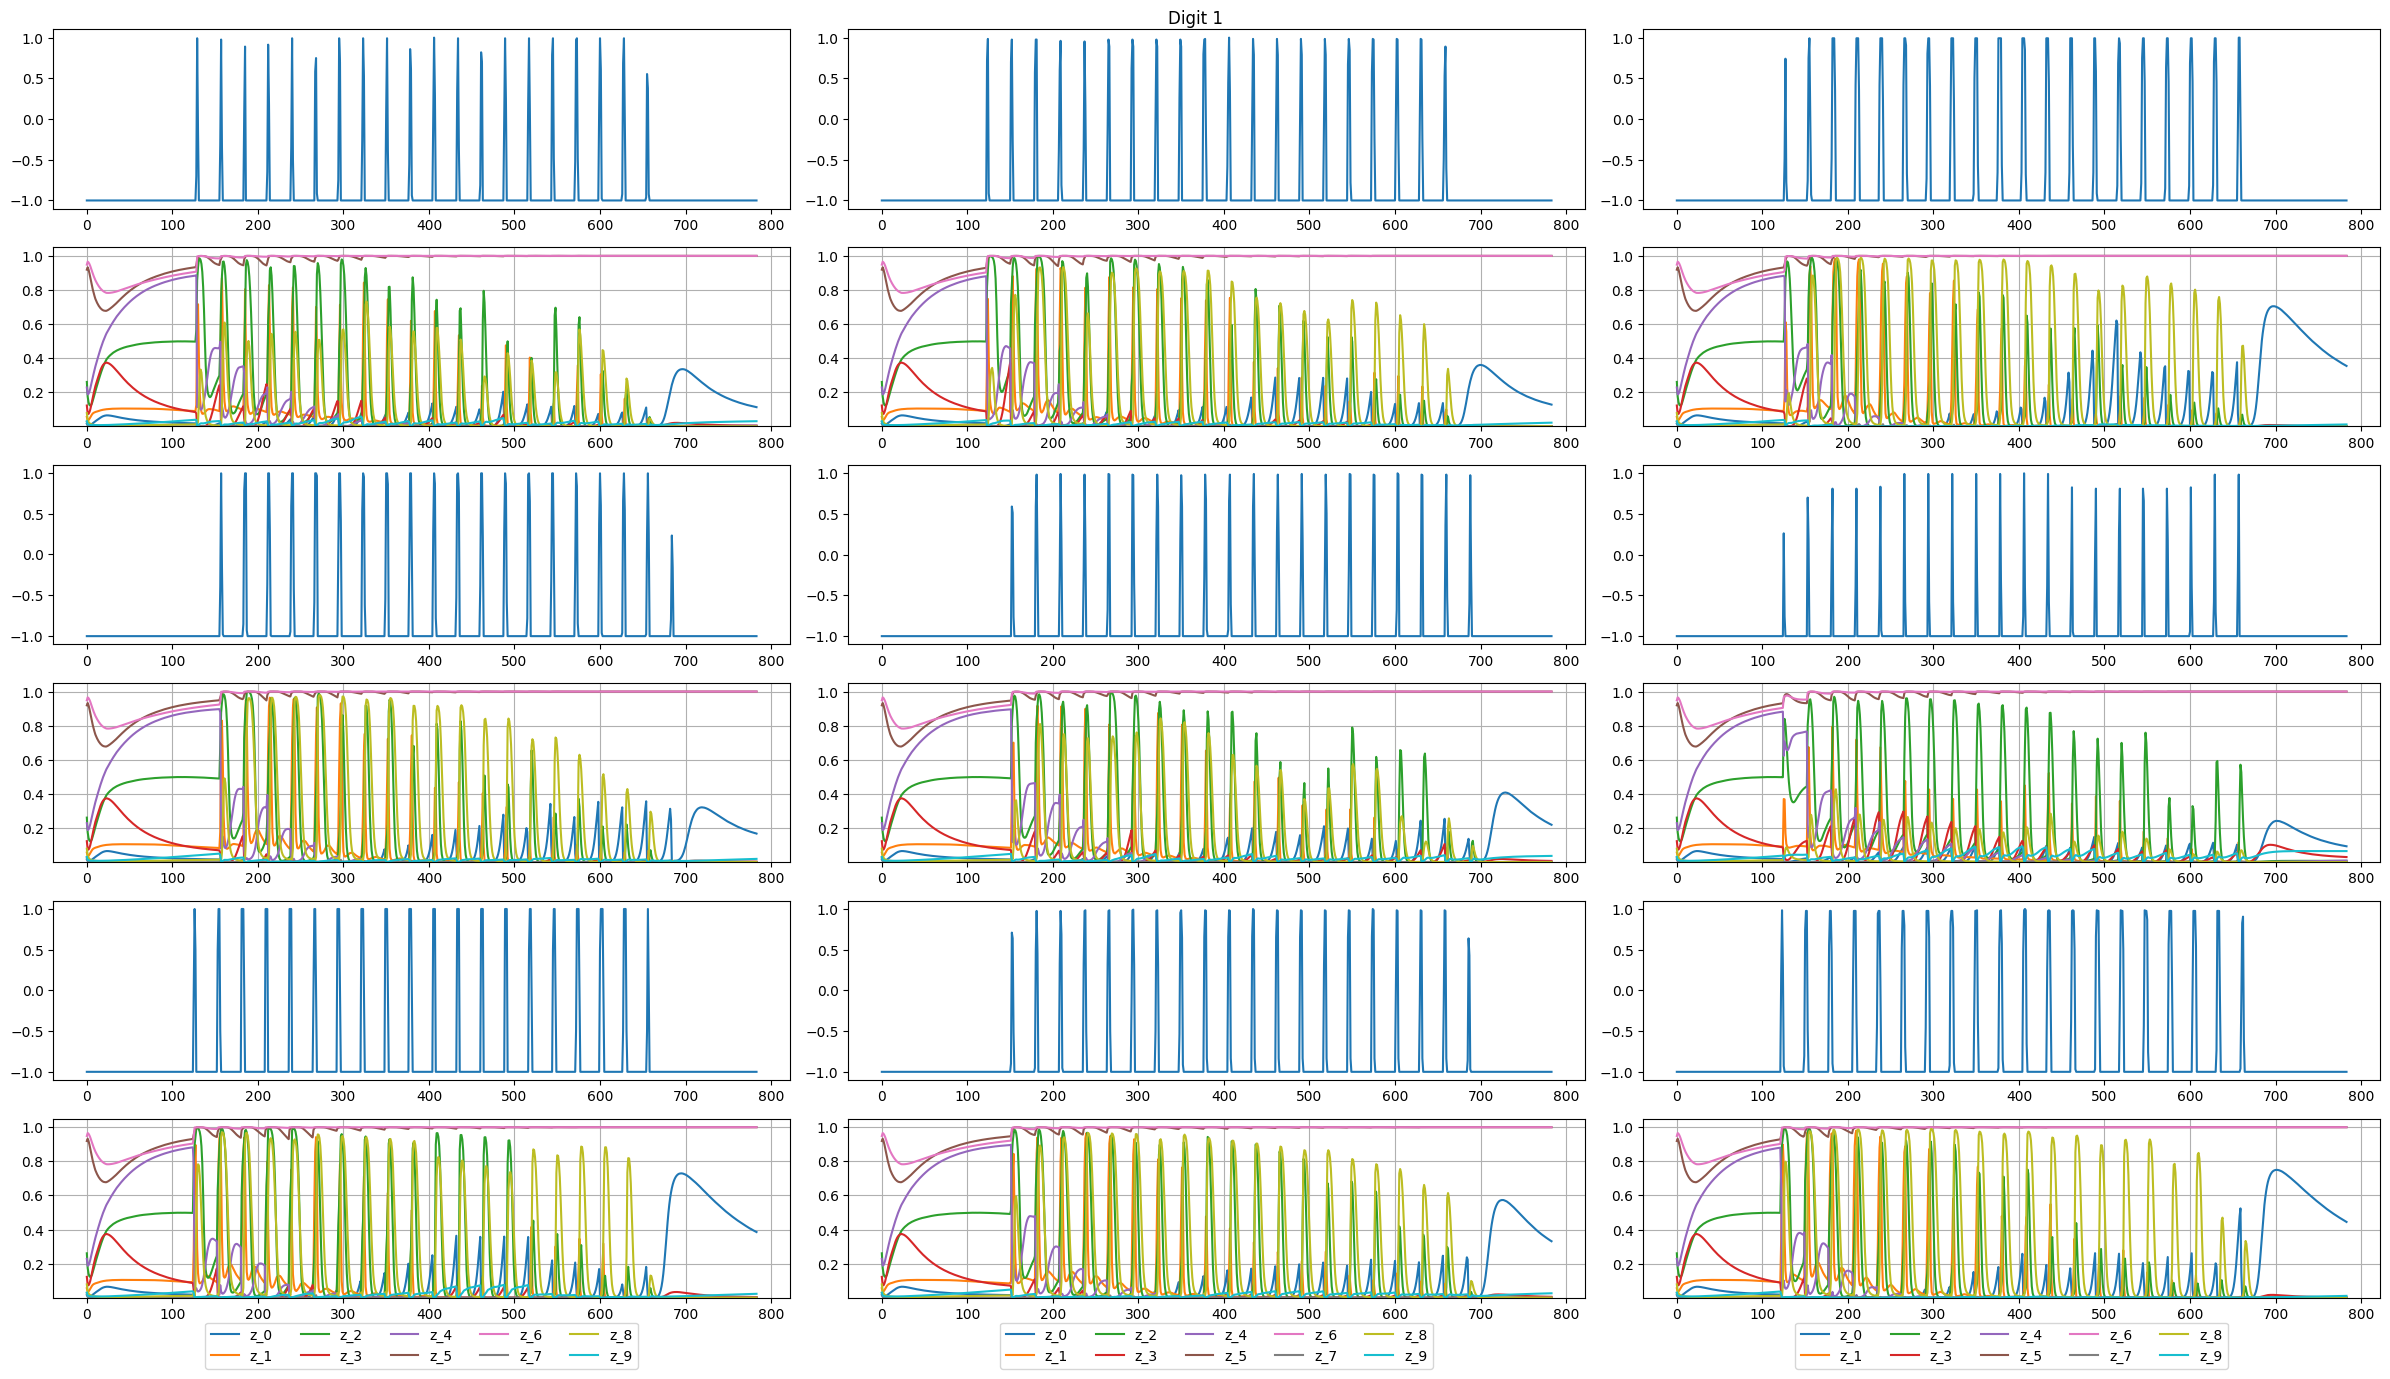

In [43]:
from utils import plot_digits

digit_to_plot = 1
plot_digits(digit_to_plot, model, restored_state.params, 'mingru_heinsen', batch_x, batch_y, plt_dir=PLT_DIR,
            variable_to_plot='z', layer_to_plot=3, nb_components_to_plot=10)

1
(10, 784, 10)


/home/tristan/LearningJAX/Flax/utils.py:378: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  for i in range(4):


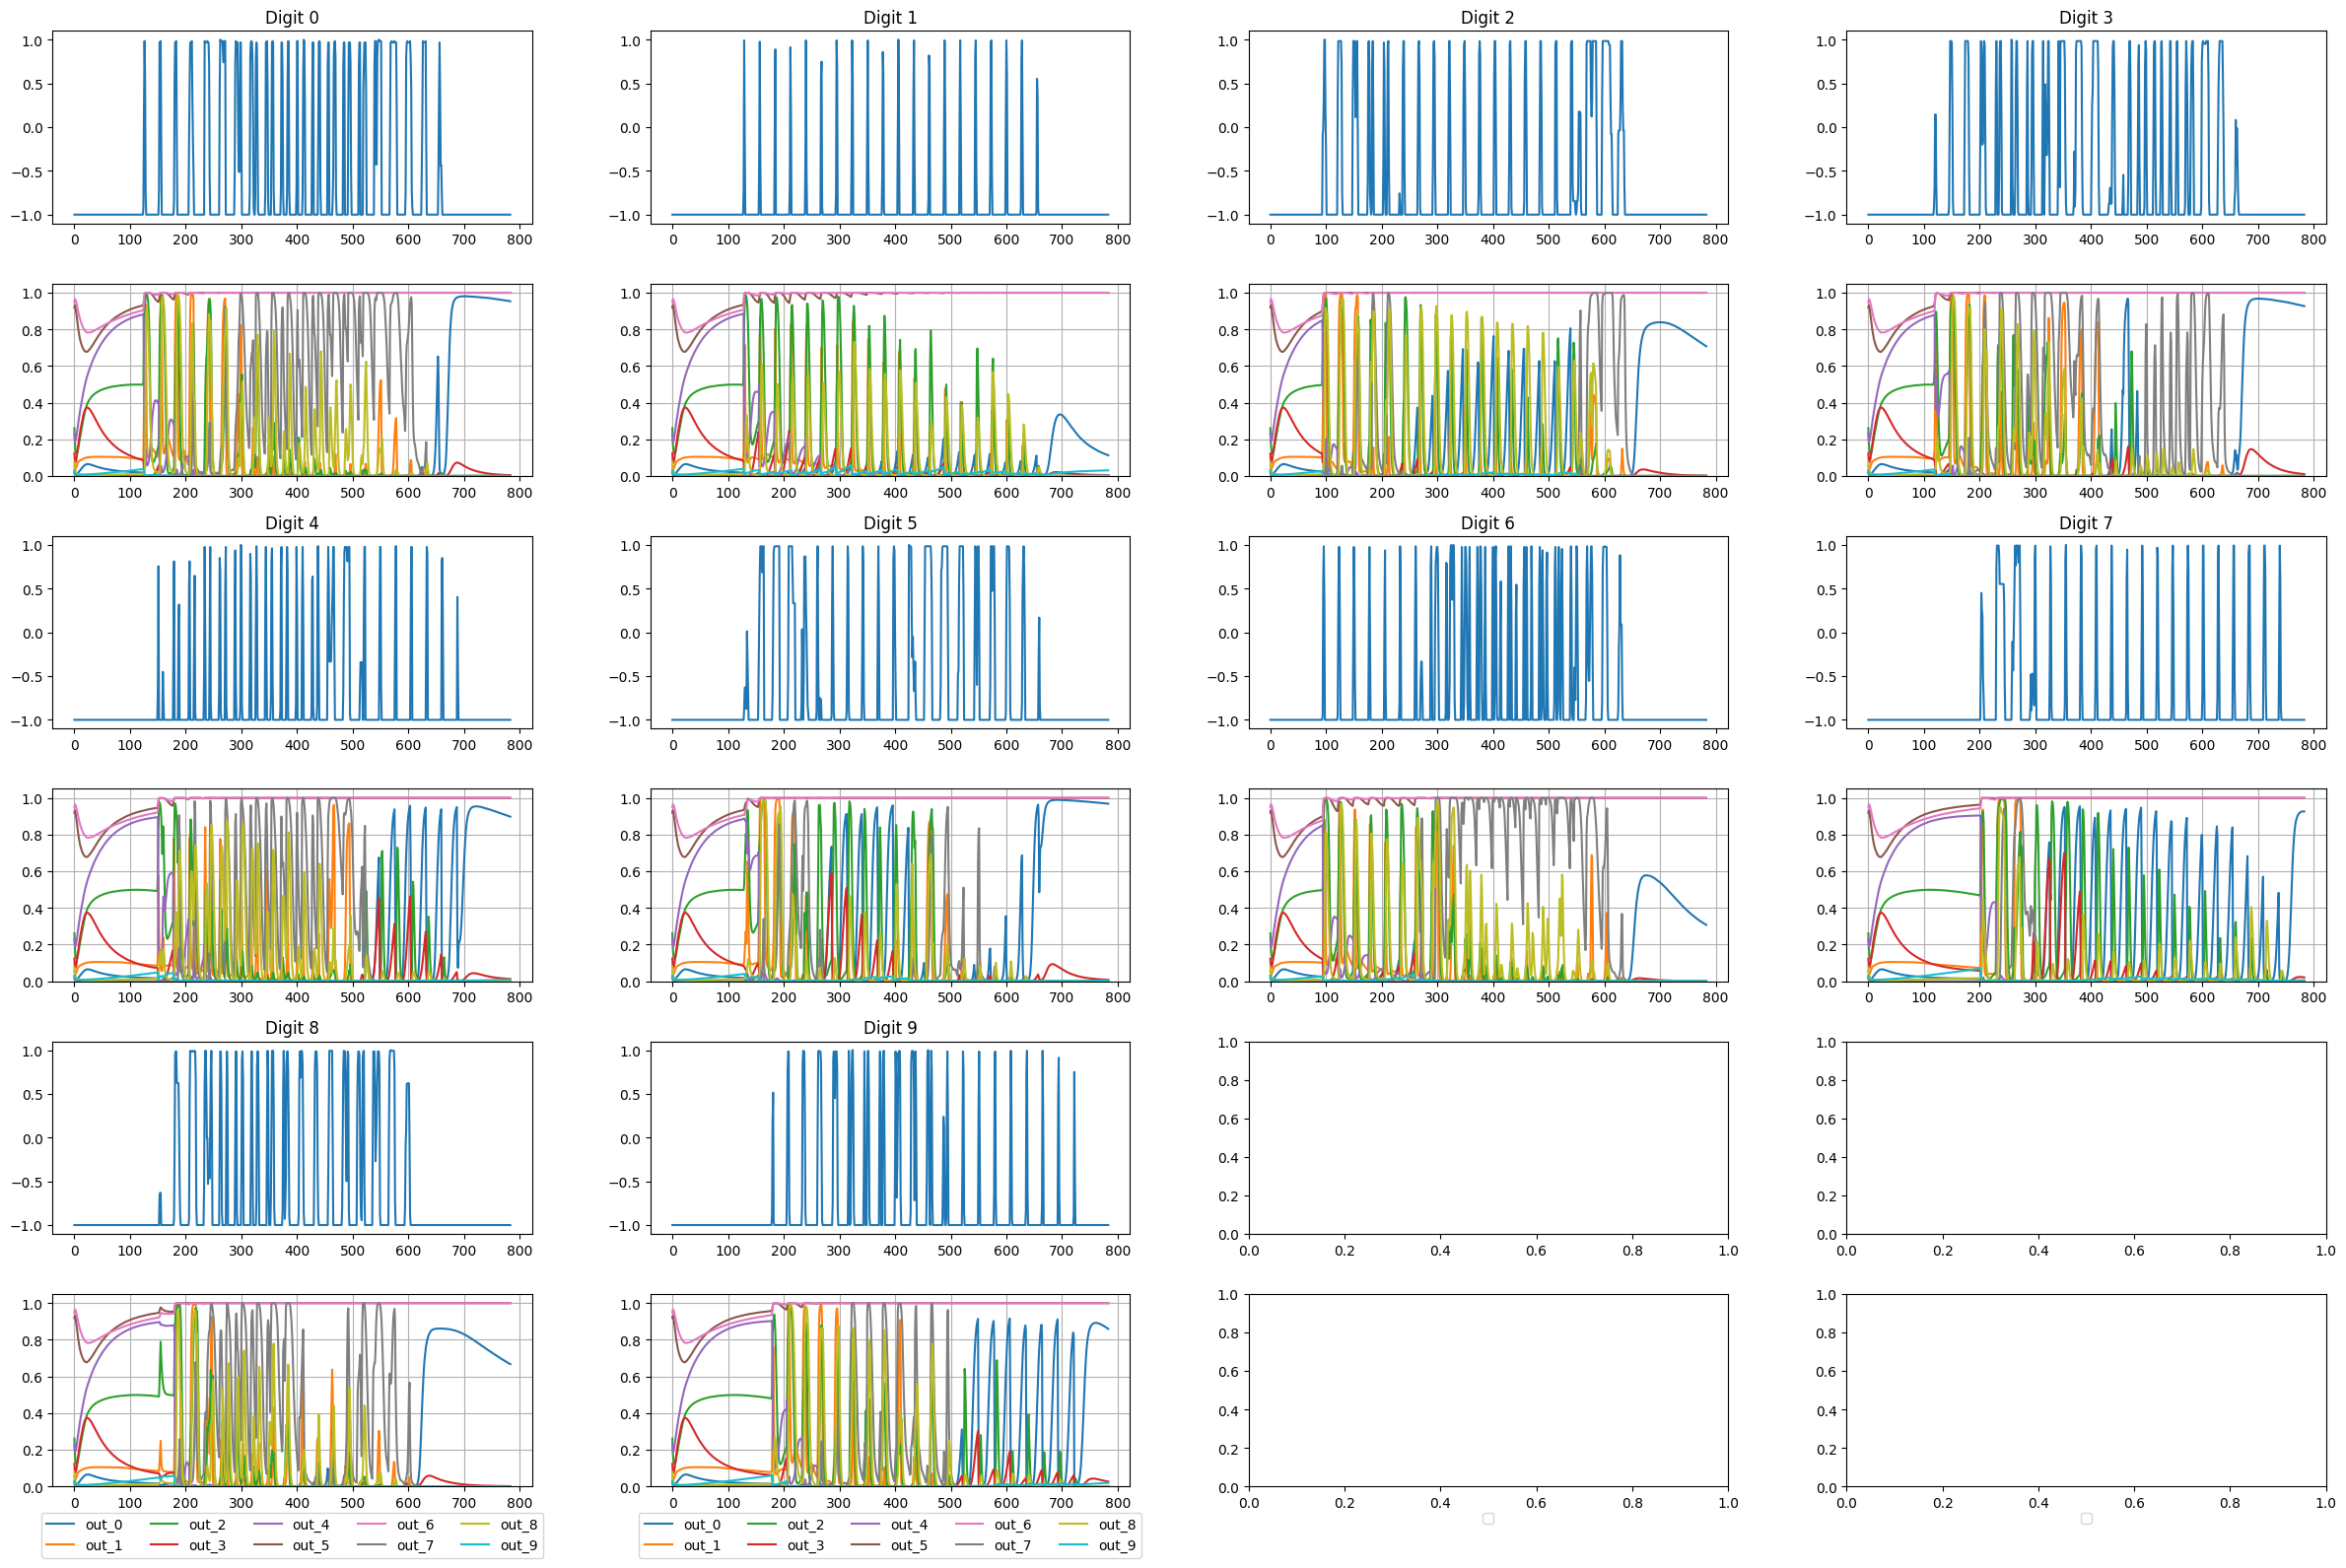

In [52]:
from utils import plot_all_digits

plot_all_digits(model, restored_state.params, 'mingru_heinsen', batch_x, batch_y, plt_dir=PLT_DIR, 
                nb_components_to_plot=10, layer_to_plot=3, variable_to_plot='z')

